In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import re

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
# from ydata_profiling import ProfileReport
import scipy.stats as stats 
from scipy.stats import mode

# Suppress warnings
import warnings 
warnings.filterwarnings("ignore")

# Preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,RandomizedSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, accuracy_score, auc, precision_recall_curve, average_precision_score

# Machine learning models
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
import xgboost as xgb
import lightgbm as lgb

# Visualization of feature importances
from yellowbrick.model_selection import FeatureImportances

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('float_format', '{:f}'.format)

In [3]:
df = pd.read_csv('../data/datasets_inter/train_features.csv')
print('This dataset has %d rows dan %d columns.\n' % df.shape)
df.head()

This dataset has 100000 rows dan 11 columns.



,Outstanding_Debt,Interest_Rate,Delay_from_due_date,Monthly_Inhand_Salary,Num_Credit_Inquiries,Credit_History_Age,Changed_Credit_Limit,Num_of_Delayed_Payment,Type_of_Loan,Total_EMI_per_month,Credit_Score
0,809.980000,3.000000,3.000000,1824.843333,4.000000,265.000000,11.270000,7.000000,135,49.574949,0
1,809.980000,3.000000,3.000000,1584.788750,4.000000,265.000000,11.270000,5.000000,135,49.574949,0
2,809.980000,3.000000,3.000000,1583.388333,4.000000,267.000000,9.270000,7.000000,135,49.574949,0
3,809.980000,3.000000,5.000000,1569.508750,4.000000,268.000000,6.270000,4.000000,135,49.574949,0
4,809.980000,3.000000,6.000000,1824.843333,4.000000,269.000000,11.270000,0.000000,135,49.574949,0


In [4]:
X = df.drop(columns=['Credit_Score'])
y = df['Credit_Score']

In [5]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [6]:
print(y_res.value_counts())

Credit_Score
0    71002
1    71002
Name: count, dtype: int64


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [9]:
# scale_pos_weight = len(y_train) / (2 * sum(y_train)) 

In [10]:
xgb_model = xgb.XGBClassifier(
    eval_metric='mlogloss', 
    tree_method='hist', 
    gpu_id=0
)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_val_scaled)

Accuracy: 0.8863
Precision: 0.8825
Recall: 0.8907
F1-Score: 0.8866
ROC AUC (XGBoost): 0.9447
Confusion Matrix:
[[12550  1680]
 [ 1549 12622]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89     14230
           1       0.88      0.89      0.89     14171

    accuracy                           0.89     28401
   macro avg       0.89      0.89      0.89     28401
weighted avg       0.89      0.89      0.89     28401



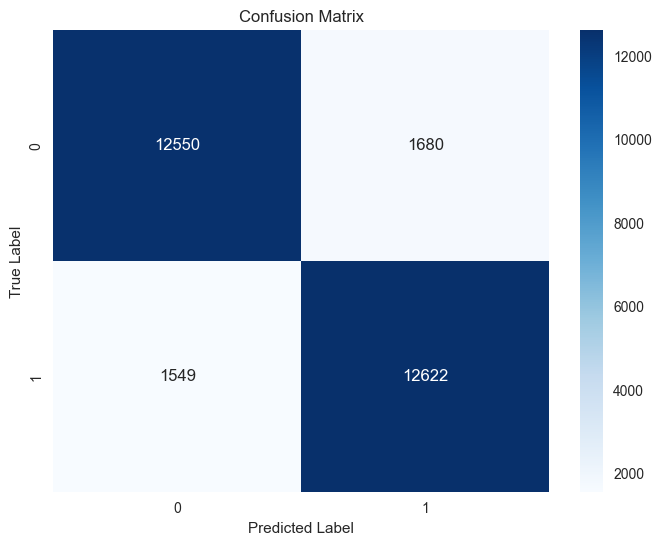

In [11]:
accuracy = accuracy_score(y_val, y_pred_xgb)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_val, y_pred_xgb, average='binary')  # Use 'micro', 'macro', or 'weighted' for multi-class
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_val, y_pred_xgb, average='binary')  # Use 'micro', 'macro', or 'weighted' for multi-class
print(f"Recall: {recall:.4f}")

# F1-Score
f1 = f1_score(y_val, y_pred_xgb, average='binary')  # Use 'micro', 'macro', or 'weighted' for multi-class
print(f"F1-Score: {f1:.4f}")

if len(np.unique(y_val)) == 2:
    y_pred_proba_xgb = xgb_model.predict_proba(X_val_scaled)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred_proba_xgb)
    print(f"ROC AUC (XGBoost): {roc_auc:.4f}")
else:
    roc_auc = roc_auc_score(y_val, xgb_model.predict_proba(X_val_scaled), multi_class='ovr', average='macro')
    print(f"ROC AUC (Multi-Class - XGBoost): {roc_auc:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred_xgb)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_val, y_pred_xgb)
print("Classification Report:")
print(class_report)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [12]:
lgb_model = lgb.LGBMClassifier()  
lgb_model.fit(X_train_scaled, y_train)
y_pred_lgb = lgb_model.predict(X_val_scaled)

[LightGBM] [Info] Number of positive: 56831, number of negative: 56772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 113603, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500260 -> initscore=0.001039
[LightGBM] [Info] Start training from score 0.001039


Accuracy: 0.8580
Precision: 0.8536
Recall: 0.8634
F1-Score: 0.8585
ROC AUC (LightGBM): 0.9245
Confusion Matrix:
[[12132  2098]
 [ 1936 12235]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86     14230
           1       0.85      0.86      0.86     14171

    accuracy                           0.86     28401
   macro avg       0.86      0.86      0.86     28401
weighted avg       0.86      0.86      0.86     28401



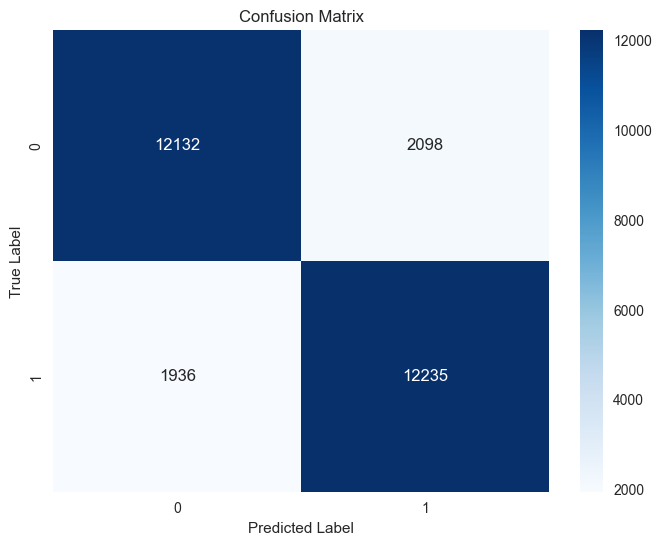

In [13]:
accuracy = accuracy_score(y_val, y_pred_lgb)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_val, y_pred_lgb, average='binary')  # Use 'micro', 'macro', or 'weighted' for multi-class
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_val, y_pred_lgb, average='binary')  # Use 'micro', 'macro', or 'weighted' for multi-class
print(f"Recall: {recall:.4f}")

# F1-Score
f1 = f1_score(y_val, y_pred_lgb, average='binary')  # Use 'micro', 'macro', or 'weighted' for multi-class
print(f"F1-Score: {f1:.4f}")

# ROC AUC for binary classification
if len(np.unique(y_val)) == 2:
    y_pred_proba_lgb = lgb_model.predict_proba(X_val_scaled)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred_proba_lgb)
    print(f"ROC AUC (LightGBM): {roc_auc:.4f}")
else:
    roc_auc = roc_auc_score(y_val, lgb_model.predict_proba(X_val_scaled), multi_class='ovr', average='macro')
    print(f"ROC AUC (Multi-Class - LightGBM): {roc_auc:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred_lgb)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_val, y_pred_lgb)
print("Classification Report:")
print(class_report)

# Plot Confusion Matrix (Optional)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [14]:
param_grid = {
    'num_leaves': [31, 63, 127],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

grid_search = GridSearchCV(estimator=lgb.LGBMClassifier(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_lgb_model = grid_search.best_estimator_

In [15]:
param_grid = {
    'learning_rate': np.logspace(-4, 0, 5), 
    'n_estimators': [100, 200, 300, 400], 
    'max_depth': [3, 5, 7, 10], 
    'subsample': [0.6, 0.8, 1.0],  
    'colsample_bytree': [0.6, 0.8, 1.0], 
    'gamma': [0, 0.1, 0.2, 0.3],  
    'reg_alpha': [0, 0.1, 1, 10],  
    'reg_lambda': [0.1, 1, 10]  
}

xgb_model = xgb.XGBClassifier(
    tree_method='gpu_hist', 
    gpu_id=0,  
    use_label_encoder=False  
)

grid_search = GridSearchCV(
    xgb_model, param_grid, cv=3, n_jobs=-1, verbose=1, scoring='accuracy'
)

grid_search.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], verbose=True)

print(f"Best Hyperparameters: {grid_search.best_params_}")

y_pred = grid_search.best_estimator_.predict(X_val_scaled)

accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix: \n{conf_matrix}")
print(f"Classification Report: \n{classification_rep}")